In [1]:
import pathlib
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs
import pandas as pd

In [2]:
team_abbreviations = {
    "ATL": 1,
    "BKN": 2,
    "BOS": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,	
    "DEN": 8,
    "DET": 9,
    "GSW": 10,	
    "HOU": 11,	
    "IND": 12,
    "LAC": 13,	
    "LAL": 14,	
    "MEM": 15, 	
    "MIA": 16,	
    "MIL": 17,	
    "MIN": 18,	
    "NOP": 19,
    "NOH": 19,	
    "NYK": 20,	
    "OKC": 21,	
    "ORL": 22,	
    "PHI": 23,	
    "PHX": 24,	
    "POR": 25,	
    "SAC": 26,	
    "SAS": 27,	
    "TOR": 28,	
    "UTA": 29,	
    "WAS": 30
}

In [3]:
class Team(object):
    def __init__(self, TeamID):
        
        self.TeamID =  TeamID 
        self.TeamName = teams.find_team_name_by_id(team_id=self.TeamID)['full_name']

        self.StartYear = 2010  
        self.LastYear = 2021
        

    def compile_active_team_data(self):
        
        points_scored_raw_data=[]
        matchup_raw_data = []
        location = []
        team_season_point_average_raw_data = []
        opponent_team_season_point_average_raw_data = []
        
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            teamLogs = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season)
            print(season)
            

            points_scored_api_data=teamLogs.get_data_frames()[0]["PTS"]
            matchup_api_data = teamLogs.get_data_frames()[0]["MATCHUP"]
         
         
        

            print(teamLogs.get_data_frames()[0])


            
            for game in range(0, len(teamLogs.get_data_frames()[0])):

                    points_scored_raw_data.append(points_scored_api_data[game])
                    #matchup_raw_data.append(matchup_api_data)
                    team_season_point_average_raw_data.append(points_scored_api_data.mean())

                    team_abbreviation= teams.find_team_name_by_id(team_id=self.TeamID)['abbreviation']
                    #print(matchup_api_data[game])
                    if " vs. " in matchup_api_data[game]:
                        location.append(1)
                    elif "@" in matchup_api_data[game]:
                        location.append(2)

                    try:   
                        #print(2222222, matchup_api_data[game], 3333, team_abbreviation)
                        matchup_api_data[game] = matchup_api_data[game].replace(team_abbreviation, "")
                        #print(matchup_api_data[game])
                    except:
                        print("Unexpected Error with removing player team")
                    try:
                        matchup_api_data[game] = matchup_api_data[game].replace(" @ ", "")
                        matchup_api_data[game] = matchup_api_data[game].replace(" vs. ", "")
                    except:
                        print("Error")
                    #print(matchup_api_data[game])
                    matchup_api_data = matchup_api_data.replace('NOH', 'NOP')
                    matchup_api_data = matchup_api_data.replace('NJN', 'BKN')
                    
                    opponentAbbreviation = matchup_api_data[game]
                    matchup_api_data[game] = team_abbreviations[opponentAbbreviation]
                    matchup_raw_data.append(matchup_api_data[game])
                    opponentID = int(teams.find_team_by_abbreviation(opponentAbbreviation)["id"])
                    if (game%10==0):
                        print(game)
                    opponentLogs = teamgamelogs.TeamGameLogs(team_id_nullable=opponentID, season_nullable=season)
                    
                    opponent_season_point_average_api_data = opponentLogs.get_data_frames()[0]["PTS"].mean()

                    opponent_team_season_point_average_raw_data.append(opponent_season_point_average_api_data)
                    time.sleep(1)
                    

        print("the lengths")
        
        print(len(points_scored_raw_data))
        print(len(matchup_raw_data))
        print(len(team_season_point_average_raw_data))
        print(len(opponent_team_season_point_average_raw_data))
        print(len(location))
        team_data = {
        #"Player Name": player_name,
        "Points Scored": points_scored_raw_data,
        #"Game Date": game_date_raw_data,
        #"MIN Played": min_played_raw_data,
        #"Win/Loss": win_loss_raw_data,
        #"Free Throws": free_throws_raw_data,
        #"Feild Goals 2pts": feild_goals_2pts_raw_data,
        #"Feild Goals 3pts": feild_goals_3pts_raw_data,
        "Matchup": matchup_raw_data,
        "Location": location,
        "Team Point Average" : team_season_point_average_raw_data,
        "Opponent Team Point Average": opponent_team_season_point_average_raw_data 
        }

        team_dataFrame = pd.DataFrame(data=team_data)
        print(team_dataFrame)

        return(team_dataFrame)


    def get_active_team_data(self):
        return(self.compile_active_team_data())



In [4]:
#Data Preparation

test = Team(1610612742).get_active_team_data()




    
opponent = test.pop('Matchup')
#test = test.replace(1.0)
test["ATL"] = (opponent == 1)*1.0
test["BKN"] = (opponent == 2)*1.0
test["BOS"] = (opponent == 3)*1.0
test["CHA"] = (opponent == 4)*1.0
test["CHI"] = (opponent == 5)*1.0
test["CLE"] = (opponent == 6)*1.0
test["DAL"] = (opponent == 7)*1.0
test["DEN"] = (opponent == 8)*1.0
test["DET"] = (opponent == 9)*1.0
test["GSW"] = (opponent == 10)*1.0
test["HOU"] = (opponent == 11)*1.0
test["IND"] = (opponent == 12)*1.0
test["LAC"] = (opponent == 13)*1.0
test["LAL"] = (opponent == 14)*1.0
test["MEM"] = (opponent == 15)*1.0
test["MIA"] = (opponent == 16)*1.0
test["MIL"] = (opponent == 17)*1.0
test["MIN"] = (opponent == 18)*1.0
test["NOP"] = (opponent == 19)*1.0
test["NYK"] = (opponent == 20)*1.0
test["OKC"] = (opponent == 21)*1.0
test["ORL"] = (opponent == 22)*1.0
test["PHI"] = (opponent == 23)*1.0
test["PHX"] = (opponent == 24)*1.0
test["POR"] = (opponent == 25)*1.0
test["SAC"] = (opponent == 26)*1.0
test["SAS"] = (opponent == 27)*1.0
test["TOR"] = (opponent == 28)*1.0
test["UTA"] = (opponent == 29)*1.0
test["WAS"] = (opponent == 30)*1.0		

'''
location = test.pop("Location")

test["Home"] = (location == 1)*1.0
test["Away"] = (location == 2)*1.0


outcome = test.pop("Win/Loss")
test["Win"] = (outcome == 1)*1.0
test["Loss"] = (outcome == 2)*1.0
'''

test    



test = test.drop(columns=["DAL"])


print(test)




2010 2021
-------------------------------------------------
2010-11
   SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION         TEAM_NAME     GAME_ID  \
0      2010-11  1610612742               DAL  Dallas Mavericks  0021001223   
1      2010-11  1610612742               DAL  Dallas Mavericks  0021001209   
2      2010-11  1610612742               DAL  Dallas Mavericks  0021001199   
3      2010-11  1610612742               DAL  Dallas Mavericks  0021001186   
4      2010-11  1610612742               DAL  Dallas Mavericks  0021001172   
5      2010-11  1610612742               DAL  Dallas Mavericks  0021001148   
6      2010-11  1610612742               DAL  Dallas Mavericks  0021001136   
7      2010-11  1610612742               DAL  Dallas Mavericks  0021001119   
8      2010-11  1610612742               DAL  Dallas Mavericks  0021001117   
9      2010-11  1610612742               DAL  Dallas Mavericks  0021001095   
10     2010-11  1610612742               DAL  Dallas Mavericks  0021001085

In [5]:
train_dataset = test.sample(frac=0.8, random_state=0)
test_dataset = test.drop(train_dataset.index)

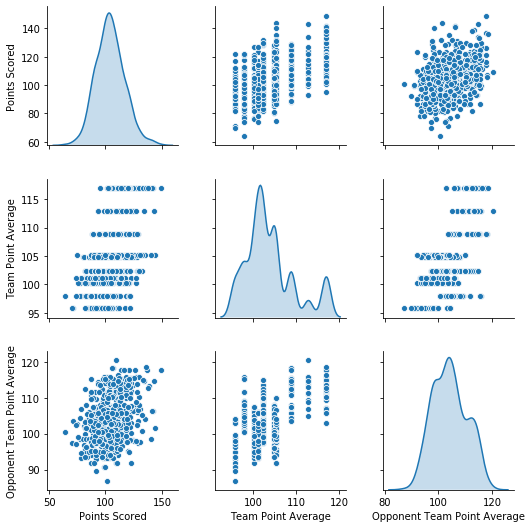

In [6]:
sns.pairplot(train_dataset[["Points Scored", "Team Point Average", "Opponent Team Point Average"]], diag_kind="kde" )

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("Points Scored")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Location,660.0,1.500000,0.500379,1.000000,1.000000,1.500000,2.000000,2.000000
Team Point Average,660.0,103.996486,5.708611,95.787879,100.243902,102.317073,105.219512,117.013333
Opponent Team Point Average,660.0,104.271349,6.322423,86.954545,99.067073,103.926829,108.332317,120.464286
ATL,660.0,0.022727,0.149146,0.000000,0.000000,0.000000,0.000000,1.000000
BKN,660.0,0.022727,0.149146,0.000000,0.000000,0.000000,0.000000,1.000000
BOS,660.0,0.022727,0.149146,0.000000,0.000000,0.000000,0.000000,1.000000
CHA,660.0,0.027273,0.163001,0.000000,0.000000,0.000000,0.000000,1.000000
CHI,660.0,0.027273,0.163001,0.000000,0.000000,0.000000,0.000000,1.000000
CLE,660.0,0.018182,0.133710,0.000000,0.000000,0.000000,0.000000,1.000000
DEN,660.0,0.054545,0.227263,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
train_labels = train_dataset.pop("Points Scored")
test_labels = test_dataset.pop("Points Scored")

In [9]:

def sigmoid(x):
    return(x - train_stats['mean'])/train_stats['std']
normed_train_data = sigmoid(train_dataset)
normed_test_data = sigmoid(test_dataset)


In [10]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.62000954],
       [-0.43633533],
       [ 0.0283709 ],
       [-0.27521798],
       [-0.14663535],
       [-0.33138454],
       [-0.29232085],
       [-0.38047317],
       [-0.33725953],
       [-0.34115925]], dtype=float32)

In [14]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,40.174671,4.591522,40.174671,265.269226,12.505430,265.269226,995
996,40.971878,4.629113,40.971878,262.645691,12.434395,262.645691,996
997,38.803436,4.514005,38.803436,273.001709,12.772139,273.001709,997
998,38.917557,4.417363,38.917557,255.147552,12.405000,255.147552,998
999,41.219604,4.722159,41.219604,265.697205,12.383130,265.697205,999


In [16]:
import matplotlib.pyplot as plt 

def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [Points Scored]")
    plt.plot(hist['epoch'], hist['mae'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")

    plt.legend()
    #plt.ylim([0,5])


    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$Points Scored^2$]")
    plt.plot(hist['epoch'], hist['mse'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
    plt.legend()
    #plt.ylim([0,20])

#plot_history(history)


.......................

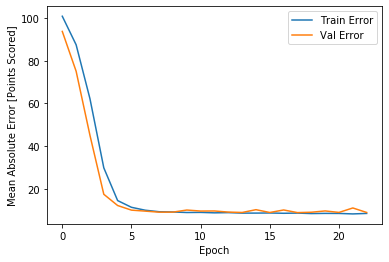

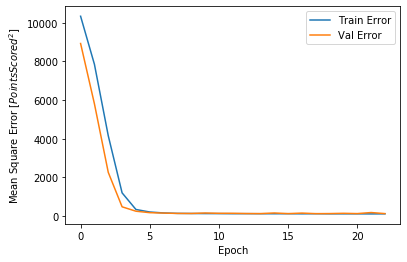

In [24]:
#early stopping

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))

Testing set Mean Abs Error:  9.35 Points Scored


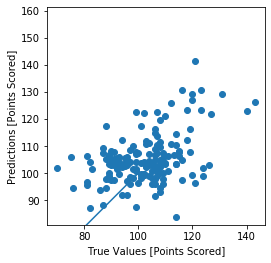

In [19]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Points Scored]")
plt.ylabel("Predictions [Points Scored]")
plt.axis('equal')
plt.axis('square')
#plt.xlim([0, plt.ylim()[1]])
#plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100, 100])